# News Articles Data Mining Notebook

In this notebook we are going to deal with data from various news articles of diggerent kinds(business,
entertainment, politics, sport and tech). We are going to create wordclouds, and perform classification and clustering for our data.

## Import Libraries


In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For Map vizualization
import folium
from nltk.corpus import genesis
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
# For random selection 
import random
# For basic cleaning and data preprocessing 
import re
import string 
# Communicating with operating and file system
import os
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# For wordcloud generating 
from wordcloud import WordCloud
nltk.download('genesis')
from PIL import Image, ImageOps

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


## Create and load datasets

Given a directory with all the data, we create 2 different data frames; one for training our algorithms, and one for testing. We use a python script that we created, and can be found in the parent directory of the project

In [2]:
%run create_dataset.py --dir data --out data/dataset.tsv
TRAIN_DATASET = "./data/train_set.tsv"
TEST_DATASET = "./data/test_set.tsv"
train_df = pd.read_csv(TRAIN_DATASET, sep='\t')
test_df = pd.read_csv(TEST_DATASET, sep='\t')

---------------------- Constructing dataset ----------------------

Running with the following configuration
	 dir --> data
	 out --> data/dataset.tsv

Creating datasets...
	An error occured on reading file: /Users/pantelis/Desktop/News-Articles-Classification/data/sport/199.txt
Datasets creating completed successfully. Time elapsed: 0.597 seconds


Let's look at the dataset info to see if everything is alright.

In [3]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1779 entries, 0 to 1778
Data columns (total 4 columns):
Id          1779 non-null int64
Title       1779 non-null object
Content     1779 non-null object
Category    1779 non-null object
dtypes: int64(1), object(3)
memory usage: 55.7+ KB


,Id,Title,Content,Category
0,209,Aviator and Vera take Bafta glory\n,\nHollywood blockbuster The Aviator and low-bu...,entertainment
1,1137,Young debut cut short by Ginepri\n,\nFifteen-year-old Donald Young's first appear...,sport
2,357,Singer Ian Brown 'in gig arrest'\n,\nFormer Stone Roses singer Ian Brown was arre...,entertainment
3,2182,EU software patent law faces axe\n,\nThe European Parliament has thrown out a bil...,tech
4,2151,PlayStation 3 processor unveiled\n,"\nThe Cell processor, which will drive Sony's ...",tech


## 1. Wordclouds

We are going to create one wordcloud for each category

### Buisness articles

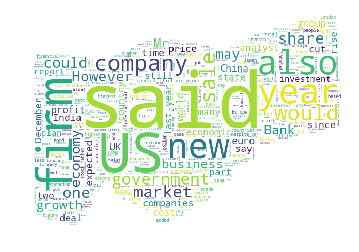

In [4]:
maskImageArray = np.array(Image.open("wordcloud_masks/business.png"))
stop_words = nltk.corpus.stopwords.words('english')
buisness_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'business']['Content'].tolist()))
plt.imshow(buisness_wordcloud)
plt.axis('off')
plt.show()

### Entertainment articles

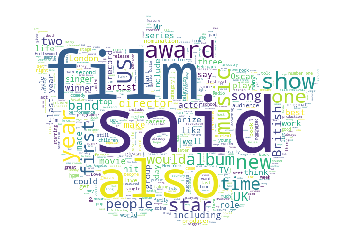

In [ ]:
maskImageArray = np.array(Image.open("wordcloud_masks/entairtenment.png"))
stop_words = nltk.corpus.stopwords.words('english')
ent_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'entertainment']['Content'].tolist()))
plt.imshow(ent_wordcloud)
plt.axis('off')
plt.show()

### Politics articles


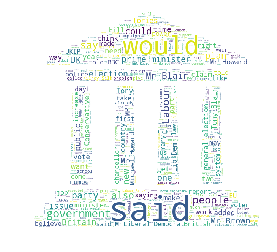

In [ ]:
maskImageArray = np.array(Image.open("wordcloud_masks/politics.png"))
stop_words = nltk.corpus.stopwords.words('english')
pol_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'politics']['Content'].tolist()))
plt.imshow(pol_wordcloud)
plt.axis('off')
plt.show()

### Sports articles

In [ ]:
maskImageArray = np.array(Image.open("wordcloud_masks/sports.png"))
stop_words = nltk.corpus.stopwords.words('english')
sport_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'sport']['Content'].tolist()))
plt.imshow(sport_wordcloud)
plt.axis('off')
plt.show()

### Tech articles

In [ ]:
maskImageArray = np.array(Image.open("wordcloud_masks/tech.png"))
stop_words = nltk.corpus.stopwords.words('english')
tech_wordcloud = WordCloud(max_words=1000,mask=maskImageArray, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Category'] == 'tech']['Content'].tolist()))
plt.imshow(tech_wordcloud)
plt.axis('off')
plt.show()

## 2. Classification 

### Data Preprocessing

Firstly, we have to preprocess our training and test set. We have to consider preprocessing on both title and content columns in order to have homogenous preprocessed data.

In [ ]:
 def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove all special characters, punctuation and spaces from string
    text = re.sub(r'\W+',' ', text)
    # remove stop words
    removed = remove_stopwords(text)
    text = "".join(removed)
    # Perform lemamatization
    lemmatizer = WordNetLemmatizer()
    lem_sentence = []
    token_words = word_tokenize(text)
    lem_sentence = [lemmatizer.lemmatize(word) for word in token_words]
    text = " ".join(lem_sentence)
    # return normalized text
    return text

In [ ]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.Title = vfunc(input_df.Title.values)
    input_df.Content = vfunc(input_df.Content.values)
    # return processed input_df
    return input_df

Let's apply the above preprocessing techniques on training set

In [ ]:
preprocessed_train_df = preprocess(train_df)
preprocessed_train_df.head()

Let's apply now the above preprocessing techniques on test set

In [ ]:
preprocessed_test_df = preprocess(test_df)
preprocessed_test_df.head()